>> This section is the modeling phase for M-1 model

In [1]:
'''
    Importing required python libraries
'''

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

try:
    import tensorflow as tf
    import keras
except:
    !pip install tensorflow
    !pip install keras
    import tensorflow as tf
    import keras

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
layers = keras.layers

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
'''
    Reading list of integer and float variables stored in file_list directory
    Also naming out model and history file
'''

cols_to_drop = ['memshpno', 'score']

_int = pd.read_csv('file_list/int_var.txt', header=None)
_int = list(_int[0])
print('# of integer columns: {}'.format(len(_int)))

_float = pd.read_csv('file_list/float_var.txt', header=None)
_float = list(_float[0])
print('# of float columns: {}'.format(len(_float)))

model_name = 'best_model_m1.h5'
history_file = 'model_history/trainHistory_m1'

# of integer columns: 1046
# of float columns: 591


In [3]:
'''
    This chunk imports the lists of training and validation file names stored during preprocessing
'''

train_files = pd.read_csv('file_list/train_files.txt', header=None)
train_files = list(train_files[0])
validation_files = pd.read_csv('file_list/validation_files.txt', header=None)
validation_files = list(validation_files[0])

In [4]:
''' 
    Generator Function reads csvs from list with each csv individually read in chunks of 4000 records 
'''

def train_generator(file_list):
    import os
    while True:
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], chunksize=4000)
            for chunk in df:
                chunk = chunk.fillna(0)
                label = chunk['score']
                chunk.drop(cols_to_drop, axis=1, inplace=True)
                deep = chunk[_float]
                wide = chunk[_int]
                inputs = [wide.values, deep.values]
                yield inputs, label

In [5]:
''' 
    Generator Function reads csvs from list with each csv individually read in chunks of 4000 records 
'''

def generator(file_list):
    import os
    while True:
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], chunksize=4000)
            for chunk in df:
                chunk = chunk.fillna(0)
                label = chunk['score']
                chunk.drop(cols_to_drop, axis=1, inplace=True)
                deep = chunk[_float]
                wide = chunk[_int]
                inputs = [wide.values, deep.values]
                yield inputs, label

In [6]:
''' 
    Keras model architecture (deep and wide architecture)
'''

wide_inputs = layers.Input(shape=(len(_int),))
wide_inputs_1 = layers.Dense(128, activation='relu')(wide_inputs)
wide_inputs_2 = layers.Dense(64, activation='relu')(wide_inputs_1)
wide_inputs_3 = layers.Dense(32, activation='relu')(wide_inputs_2)

dense_inputs = layers.Input(shape=(len(_float),))
dense_inputs_1 = layers.Dense(128, activation='relu')(dense_inputs)
dense_inputs_2 = layers.Dense(64, activation='relu')(dense_inputs_1)
dense_inputs_3 = layers.Dense(32, activation='relu')(dense_inputs_2)

merge = layers.concatenate([wide_inputs_3, dense_inputs_3])

hidden1 = layers.Dense(32, activation='relu')(merge)
hidden2 = layers.Dense(16, activation='relu')(hidden1)
output = layers.Dense(1, activation='linear')(hidden2)

model = keras.Model(inputs=[wide_inputs, dense_inputs], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
''' 
    Visualizing model architecture
'''

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1046)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 591)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          134016      input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          75776       input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (D

In [8]:
''' 
    Initializing train and validation generators
'''

train_g = train_generator(train_files)
validation_g = generator(validation_files)

In [9]:
''' 
    Early Stopping and Call Backs 
'''

model_path = "model"
path = os.path.join(model_path, model_name)
callbacks = [EarlyStopping(monitor='val_loss', patience=3), 
                 ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True)]

In [ ]:
''' 
    Model execution
'''

final_model = model.fit_generator(train_g, epochs=10, steps_per_epoch=(len(train_files)*4), \
                                  validation_data=validation_g, validation_steps=(len(validation_files)*4), \
                                 callbacks=callbacks, max_q_size=1, use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
720/720 [==============================] - 739s 1s/step - loss: 0.0157 - mean_absolute_error: 0.0772 - mean_squared_error: 0.0157 - val_loss: 0.0163 - val_mean_absolute_error: 0.0827 - val_mean_squared_error: 0.0163
Epoch 6/10
720/720 [==============================] - 731s 1s/step - loss: 0.0157 - mean_absolute_error: 0.0770 - mean_squared_error: 0.0157 - val_loss: 0.0163 - val_mean_absolute_error: 0.0833 - val_mean_squared_error: 0.0163


In [ ]:
''' 
    Saving model history for future visualization
'''

with open(history_file, 'wb') as handle: 
    pickle.dump(final_model.history, handle)

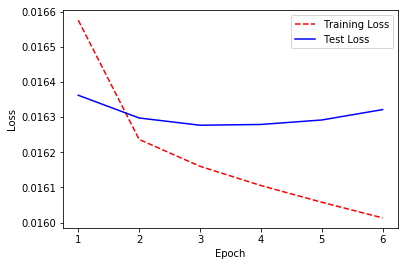

In [ ]:
''' 
    Plotting training and validation mean squared error
'''

training_loss = final_model.history['loss']
test_loss = final_model.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

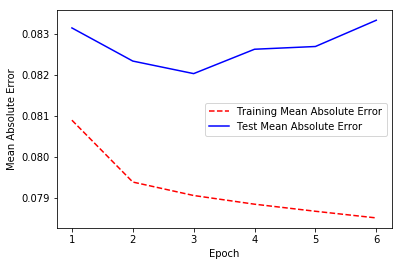

In [ ]:
''' 
    Plotting training and validation mean_absolute_error
'''

training_acc = final_model.history['mean_absolute_error']
test_acc = final_model.history['val_mean_absolute_error']

epoch_count = range(1, len(training_acc) + 1)

plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Mean Absolute Error', 'Test Mean Absolute Error'])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show();

# Test Section

>> This is the test section where unseen test data is predicted through the M-1 model created in previous section. Following section extract labels on the validation dataset as well

In [1]:
'''
    Importing required python libraries
'''

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

try:
    import tensorflow as tf
    import keras
except:
    !pip install tensorflow
    !pip install keras
    import tensorflow as tf
    import keras

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
layers = keras.layers

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
'''
    Reading list of integer and float variables stored in file_list directory
    Also naming out model and history file
'''

cols_to_drop = ['memshpno', 'score']

_int = pd.read_csv('file_list/int_var.txt', header=None)
_int = list(_int[0])
print('# of integer columns: {}'.format(len(_int)))

_float = pd.read_csv('file_list/float_var.txt', header=None)
_float = list(_float[0])
print('# of float columns: {}'.format(len(_float)))

model_name = 'best_model_m1.h5'
history_file = 'model_history/trainHistory_m1'

# of integer columns: 1046
# of float columns: 591


In [3]:
''' 
    Generator Function reads csvs from list with each csv individually read in chunks of 4000 records 
'''

def generator(file_list):
    import os
    while True:
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], chunksize=4000)
            for chunk in df:
                chunk = chunk.fillna(0)
                label = chunk['score']
                chunk.drop(cols_to_drop, axis=1, inplace=True)
                deep = chunk[_float]
                wide = chunk[_int]
                inputs = [wide.values, deep.values]
                yield inputs, label

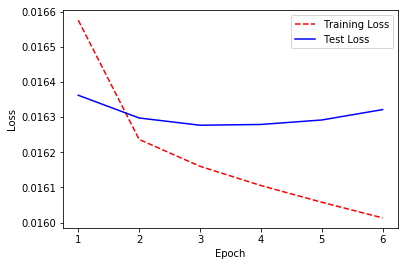

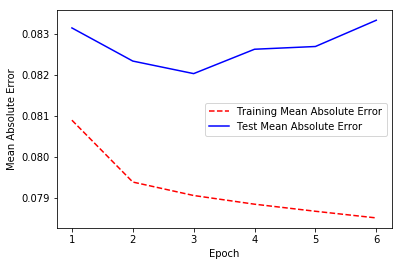

In [4]:
''' 
    Plotting training and validation mean_squared_error and mean_absolute_error
'''

try:
    history = pickle.load(open(history_file, 'rb'))

    # plot training and validation loss
    training_loss = history['loss']
    test_loss = history['val_loss']

    epoch_count = range(1, len(training_loss) + 1)

    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

    # Get training and validation accuracies
    training_acc = history['mean_absolute_error']
    test_acc = history['val_mean_absolute_error']

    epoch_count = range(1, len(training_acc) + 1)

    plt.plot(epoch_count, training_acc, 'r--')
    plt.plot(epoch_count, test_acc, 'b-')
    plt.legend(['Training Mean Absolute Error', 'Test Mean Absolute Error'])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.show();
except:
    pass

In [5]:
'''
    This chunk imports the lists of test file names stored during preprocessing
'''

test_files = pd.read_csv('file_list/test_files.txt', header=None)
test_files = list(test_files[0])

In [6]:
'''
    Loading model and initializing test generator
'''

model_path = "model"
model = load_model(os.path.join(model_path, model_name))
test_generator = generator(test_files)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
'''
    Loading original test labels for comparison with predictions
'''

original_labels = pd.read_csv('file_list/test_labels.csv')

In [8]:
'''
    Predicitons
'''

predictions = model.predict_generator(test_generator, steps=len(test_files)*4, verbose=1)

40/40 [==============================] - 104s 3s/step


In [ ]:
'''
    Adding predictions to original labels
'''

original_labels['propensity'] = predictions

In [10]:
'''
    Mean_square_error on test set
'''

from sklearn.metrics import mean_squared_error
mean_squared_error(original_labels.score, original_labels.propensity)

0.016254119555781942

# Loss on Validation Set

In [11]:
'''
    This chunk imports the lists of validation file names store during preprocessing
'''

test_files = pd.read_csv('file_list/validation_files.txt', header=None)
test_files = list(test_files[0])

In [12]:
'''
    Loading model and initializing test generator
'''

model_path = "model"
model = load_model(os.path.join(model_path, model_name))
test_generator = generator(test_files)

In [ ]:
'''
    Loading original test labels for comparison with predictions
'''

original_labels = pd.read_csv('file_list/validation_labels.csv')

In [14]:
'''
    Predicitons
'''

predictions = model.predict_generator(test_generator, steps=len(test_files)*4, verbose=1)

40/40 [==============================] - 32s 801ms/step


In [ ]:
'''
    Adding predictions to original labels
'''

original_labels['propensity'] = predictions

In [16]:
'''
    Mean_square_error on validation set
'''

mean_squared_error(original_labels.score, original_labels.propensity)

0.01627688585308819